In [1]:
from google.colab import files

# Upload files
uploaded = files.upload()

Saving pizza_sales_cleaned (1).csv to pizza_sales_cleaned (1).csv
Saving Pizza_ingredients.csv to Pizza_ingredients.csv


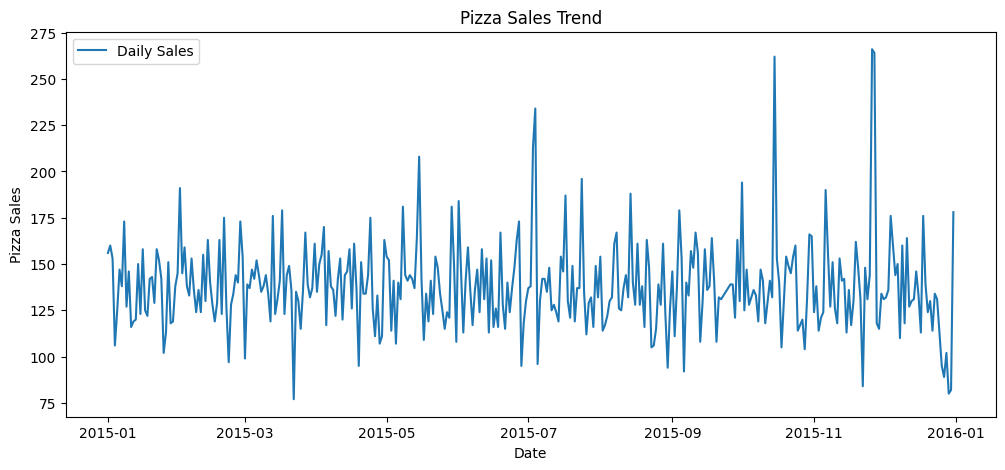

DEBUG:cmdstanpy:input tempfile: /tmp/tmp_wpm787u/4pqexgs1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_wpm787u/_yeg8k5b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92681', 'data', 'file=/tmp/tmp_wpm787u/4pqexgs1.json', 'init=/tmp/tmp_wpm787u/_yeg8k5b.json', 'output', 'file=/tmp/tmp_wpm787u/prophet_modelv720yfmd/prophet_model-20250204133256.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:32:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:32:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAPE (SARIMA): 0.37
MAPE (Prophet): 0.17
Purchase order saved successfully.


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error

df_sales = pd.read_csv("pizza_sales_cleaned (1).csv", encoding="utf-8")
df_ingredients = pd.read_csv("Pizza_ingredients.csv", encoding="utf-8")

df_sales['order_date'] = pd.to_datetime(df_sales['order_date'])
daily_sales = df_sales.groupby('order_date')['quantity'].sum().reset_index()

plt.figure(figsize=(12, 5))
plt.plot(daily_sales['order_date'], daily_sales['quantity'], label="Daily Sales")
plt.xlabel("Date")
plt.ylabel("Pizza Sales")
plt.title("Pizza Sales Trend")
plt.legend()
plt.show()

sarima_model = SARIMAX(daily_sales['quantity'], order=(1,1,1), seasonal_order=(1,1,1,7))
sarima_result = sarima_model.fit()
future_dates = pd.date_range(start=daily_sales['order_date'].max() + pd.Timedelta(days=1), periods=7, freq='D')
forecast_sarima = sarima_result.predict(start=len(daily_sales), end=len(daily_sales)+6)

prophet_df = daily_sales.rename(columns={'order_date': 'ds', 'quantity': 'y'})
prophet = Prophet(yearly_seasonality=True, daily_seasonality=False, weekly_seasonality=True)
prophet.fit(prophet_df)
future = prophet.make_future_dataframe(periods=7)
forecast_prophet = prophet.predict(future)

actual = daily_sales['quantity'][-7:].values
predicted_sarima = forecast_sarima[:7]
predicted_prophet = forecast_prophet['yhat'][-7:].values

mape_sarima = mean_absolute_percentage_error(actual, predicted_sarima)
mape_prophet = mean_absolute_percentage_error(actual, predicted_prophet)
print(f"MAPE (SARIMA): {mape_sarima:.2f}")
print(f"MAPE (Prophet): {mape_prophet:.2f}")

best_forecast = forecast_sarima if mape_sarima < mape_prophet else forecast_prophet['yhat'][:7].values

forecast_df = pd.DataFrame({"order_date": future_dates, "predicted_sales": np.round(best_forecast, 2)})

pizza_sales_avg = df_sales.groupby('pizza_name_id')['quantity'].mean().reset_index()
pizza_sales_avg.rename(columns={'quantity': 'avg_quantity'}, inplace=True)
forecast_df = forecast_df.assign(key=1).merge(pizza_sales_avg.assign(key=1), on='key').drop(columns=['key'])

forecast_df['pizza_sales_forecast'] = (forecast_df['predicted_sales'] *
                                       (forecast_df['avg_quantity'] / forecast_df['avg_quantity'].sum()))

forecast_df = forecast_df.merge(df_ingredients, on='pizza_name_id', how='inner')
forecast_df.dropna(subset=['pizza_ingredients'], inplace=True)

forecast_df['pizza_sales_forecast'] /= forecast_df['pizza_sales_forecast'].sum()
forecast_df['pizza_sales_forecast'] *= forecast_df['predicted_sales'].sum()

forecast_df['ingredient_demand'] = np.round(forecast_df['pizza_sales_forecast'] * forecast_df['Items_Qty_In_Grams'], 2)

final_purchase_order = forecast_df.groupby(['pizza_ingredients'])['ingredient_demand'].sum().reset_index()
final_purchase_order['ingredient_demand'] = final_purchase_order['ingredient_demand'].round(2)

final_purchase_order.to_csv("purchase_order.csv", index=False)
print("Purchase order saved successfully.")




In [5]:
print(future.info())
print(future.isnull().sum())
print(future.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ds          365 non-null    datetime64[ns]
 1   is_weekend  365 non-null    bool          
 2   week        365 non-null    UInt32        
 3   month       365 non-null    int32         
dtypes: UInt32(1), bool(1), datetime64[ns](1), int32(1)
memory usage: 6.5 KB
None
ds            0
is_weekend    0
week          0
month         0
dtype: int64
          ds  is_weekend  week  month
0 2015-01-01       False     1      1
1 2015-01-02       False     1      1
2 2015-01-03        True     1      1
3 2015-01-04        True     1      1
4 2015-01-05       False     2      1


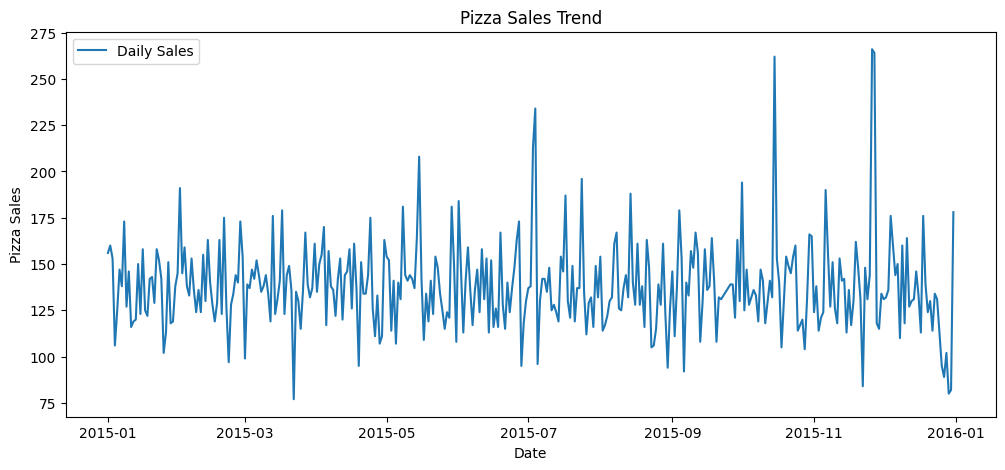

DEBUG:cmdstanpy:input tempfile: /tmp/tmp_wpm787u/t3go9duz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_wpm787u/tdv3vwhy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96071', 'data', 'file=/tmp/tmp_wpm787u/t3go9duz.json', 'init=/tmp/tmp_wpm787u/tdv3vwhy.json', 'output', 'file=/tmp/tmp_wpm787u/prophet_modelbd_pxlzz/prophet_model-20250204133107.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:31:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:31:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAPE (SARIMA): 0.37
MAPE (Prophet): 0.54
Purchase order saved successfully.


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error

df_sales = pd.read_csv("pizza_sales_cleaned (1).csv", encoding="utf-8")
df_ingredients = pd.read_csv("Pizza_ingredients.csv", encoding="utf-8")

df_sales['order_date'] = pd.to_datetime(df_sales['order_date'])

df_sales['is_weekend'] = (df_sales['order_date'].dt.dayofweek >= 5).astype(int)
df_sales['week'] = df_sales['order_date'].dt.isocalendar().week.astype(int)
df_sales['month'] = df_sales['order_date'].dt.month.astype(int)

daily_sales = df_sales.groupby('order_date').agg({'quantity': 'sum', 'is_weekend': 'first', 'week': 'first', 'month': 'first'}).reset_index()

plt.figure(figsize=(12, 5))
plt.plot(daily_sales['order_date'], daily_sales['quantity'], label="Daily Sales")
plt.xlabel("Date")
plt.ylabel("Pizza Sales")
plt.title("Pizza Sales Trend")
plt.legend()
plt.show()

sarima_model = SARIMAX(daily_sales['quantity'], order=(1,1,1), seasonal_order=(1,1,1,7))



In [7]:
from google.colab import files
files.download("purchase_order.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

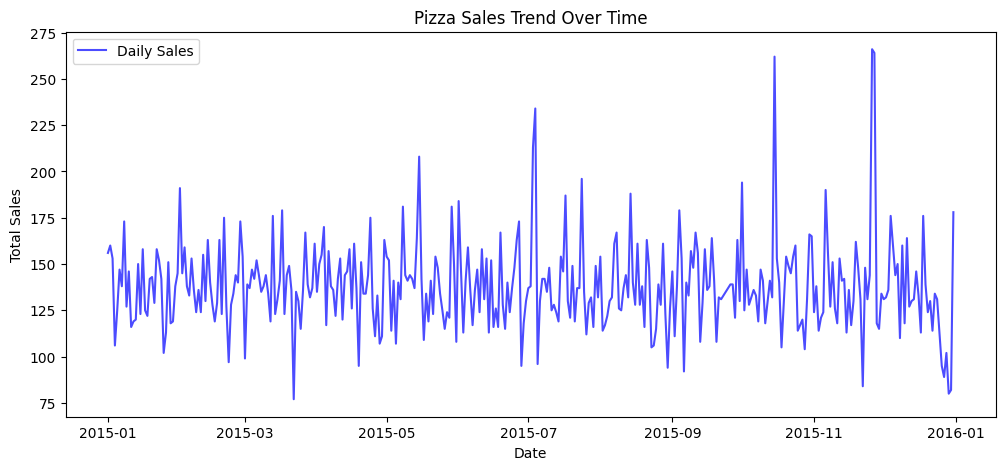

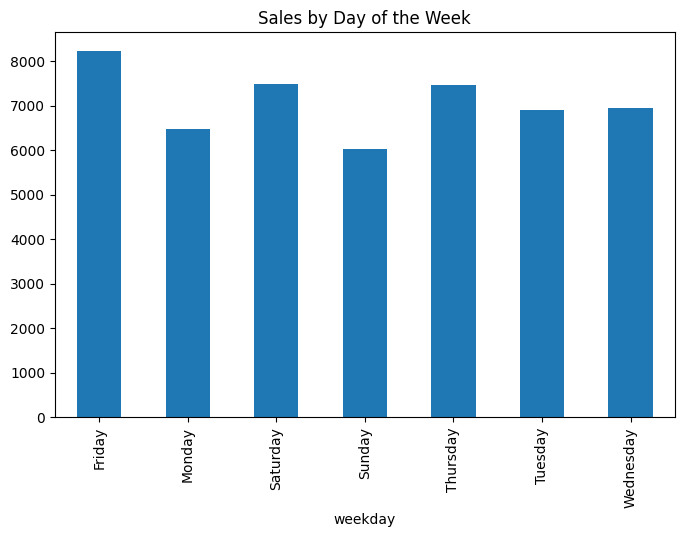

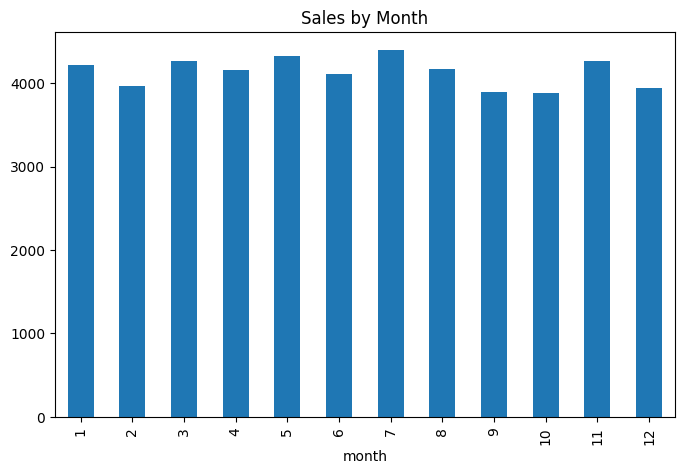

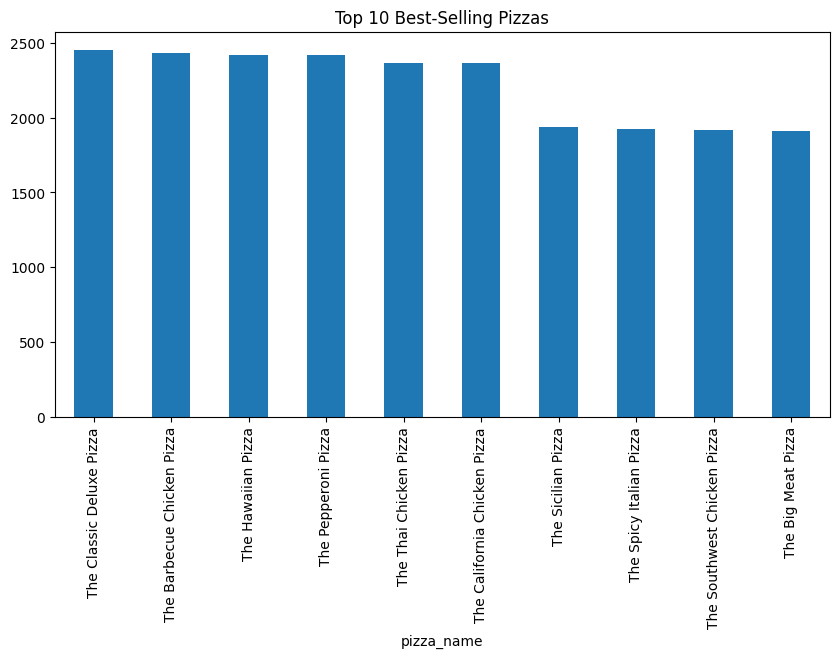

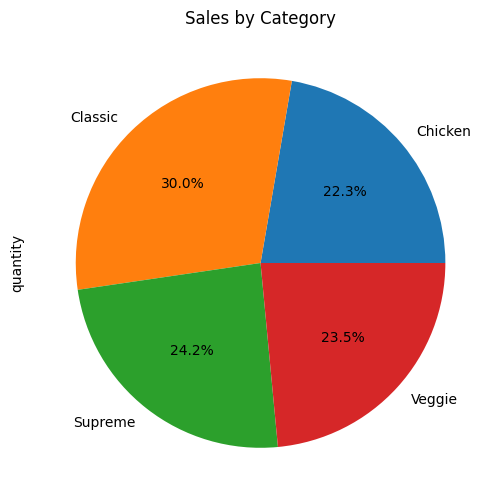

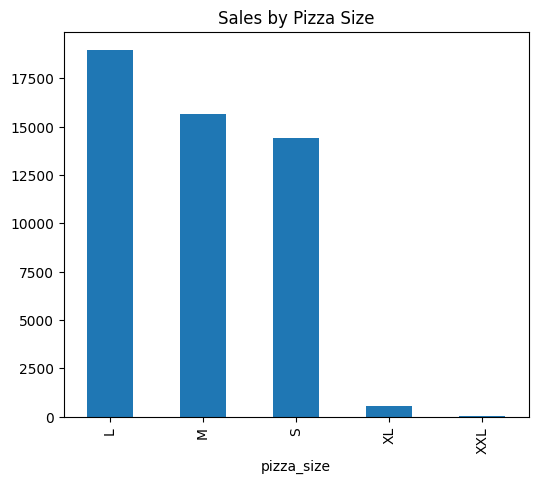

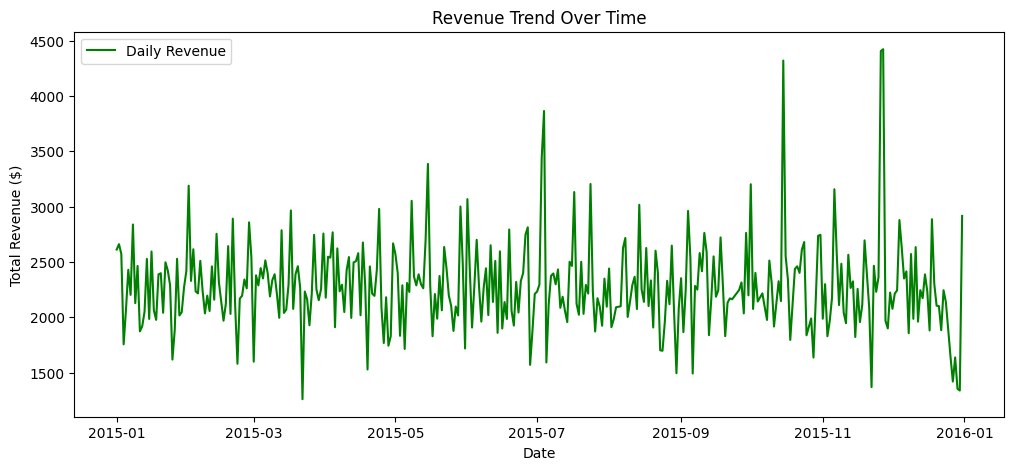

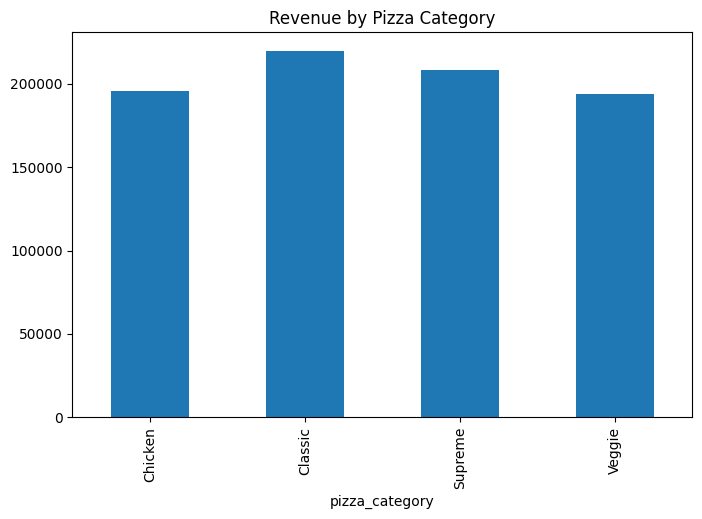

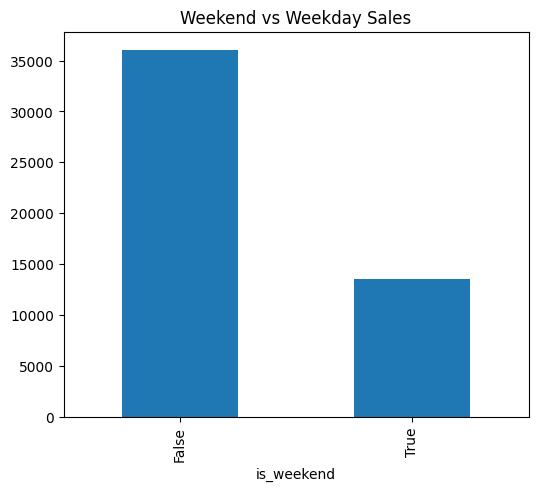

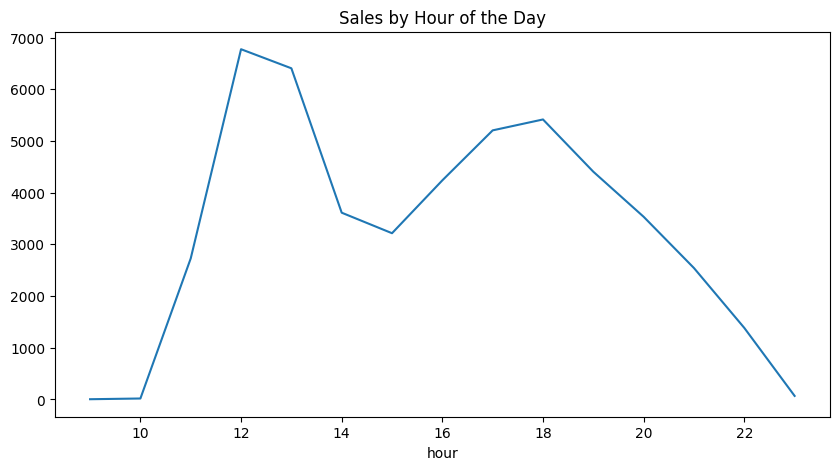

KeyError: 'pizza_ingredients'

In [10]:
#EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Convert order_date to datetime
df_sales['order_date'] = pd.to_datetime(df_sales['order_date'])

# 1️⃣ Sales Trends Over Time
daily_sales = df_sales.groupby('order_date')['quantity'].sum().reset_index()
plt.figure(figsize=(12,5))
plt.plot(daily_sales['order_date'], daily_sales['quantity'], label="Daily Sales", color="blue", alpha=0.7)
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.title("Pizza Sales Trend Over Time")
plt.legend()
plt.show()

# 2️⃣ Seasonality Analysis
df_sales['weekday'] = df_sales['order_date'].dt.day_name()
df_sales['month'] = df_sales['order_date'].dt.month
df_sales.groupby('weekday')['quantity'].sum().plot(kind='bar', title="Sales by Day of the Week", figsize=(8,5))
plt.show()
df_sales.groupby('month')['quantity'].sum().plot(kind='bar', title="Sales by Month", figsize=(8,5))
plt.show()

# 3️⃣ Top-Selling Pizzas & Categories
df_sales.groupby('pizza_name')['quantity'].sum().sort_values(ascending=False).head(10).plot(kind='bar', title="Top 10 Best-Selling Pizzas", figsize=(10,5))
plt.show()
df_sales.groupby('pizza_category')['quantity'].sum().plot(kind='pie', autopct='%1.1f%%', title="Sales by Category", figsize=(6,6))
plt.show()
df_sales.groupby('pizza_size')['quantity'].sum().plot(kind='bar', title="Sales by Pizza Size", figsize=(6,5))
plt.show()

# 4️⃣ Revenue Analysis
df_sales['revenue'] = df_sales['quantity'] * df_sales['unit_price']
daily_revenue = df_sales.groupby('order_date')['revenue'].sum().reset_index()
plt.figure(figsize=(12,5))
plt.plot(daily_revenue['order_date'], daily_revenue['revenue'], label="Daily Revenue", color='green')
plt.xlabel("Date")
plt.ylabel("Total Revenue ($)")
plt.title("Revenue Trend Over Time")
plt.legend()
plt.show()

df_sales.groupby('pizza_category')['revenue'].sum().plot(kind='bar', title="Revenue by Pizza Category", figsize=(8,5))
plt.show()

# 5️⃣ Customer Demand Patterns
df_sales['is_weekend'] = df_sales['weekday'].isin(['Saturday', 'Sunday'])
df_sales.groupby('is_weekend')['quantity'].sum().plot(kind='bar', title="Weekend vs Weekday Sales", figsize=(6,5))
plt.show()
df_sales.groupby('hour')['quantity'].sum().plot(kind='line', title="Sales by Hour of the Day", figsize=(10,5))
plt.show()




In [11]:
ingredient_demand = df_sales.merge(df_ingredients, on='pizza_name_id', how='left')

print(ingredient_demand.columns)
print(ingredient_demand.head())

Index(['pizza_id', 'order_id', 'pizza_name_id', 'quantity', 'order_date',
       'order_time', 'unit_price', 'total_price', 'pizza_size',
       'pizza_category', 'pizza_ingredients_x', 'pizza_name_x', 'year',
       'month', 'day', 'weekday', 'week', 'hour', 'is_weekend',
       'revenue_per_pizza', 'pizza_category_encoded', 'pizza_size_encoded',
       'revenue', 'pizza_name_y', 'pizza_ingredients_y', 'Items_Qty_In_Grams'],
      dtype='object')
   pizza_id  order_id  pizza_name_id  quantity order_date order_time  \
0         1         1     hawaiian_m         1 2015-01-01   11:38:36   
1         1         1     hawaiian_m         1 2015-01-01   11:38:36   
2         1         1     hawaiian_m         1 2015-01-01   11:38:36   
3         2         2  classic_dlx_m         1 2015-01-01   11:57:40   
4         2         2  classic_dlx_m         1 2015-01-01   11:57:40   

   unit_price  total_price pizza_size pizza_category  ... week hour  \
0       13.25        13.25          M       

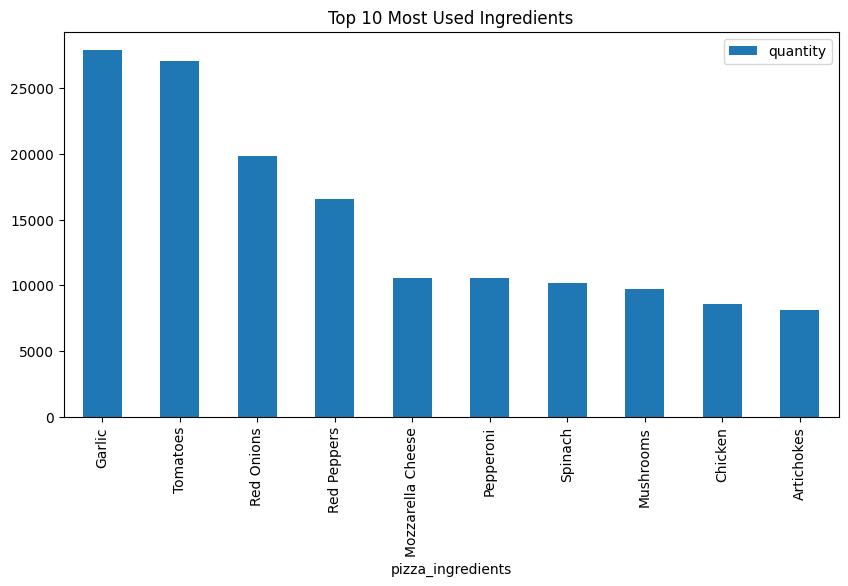

In [12]:
ingredient_demand = df_sales.merge(df_ingredients, on='pizza_name_id', how='left')

# Ensure correct column reference
if 'pizza_ingredients_y' in ingredient_demand.columns:
    ingredient_demand.rename(columns={'pizza_ingredients_y': 'pizza_ingredients'}, inplace=True)

# Group by ingredients and sum quantities
ingredient_demand = ingredient_demand.groupby('pizza_ingredients')['quantity'].sum().reset_index()

# Plot the top 10 ingredients
ingredient_demand.sort_values(by='quantity', ascending=False).head(10).plot(
    kind='bar', x='pizza_ingredients', y='quantity', title="Top 10 Most Used Ingredients", figsize=(10,5)
)
plt.show()
